# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq

import re

# Functions

In [ ]:
def analyze_panel(df_panel, panel_name):
    time = df_panel["time_sec"].values
    voltage = df_panel["voltage"].values

    voltage_detrended = voltage - np.mean(voltage)

    N = len(time)
    dt = np.mean(np.diff(time))
    freqs = fftfreq(N, dt)
    fft_values = fft(voltage_detrended)
    power = np.abs(fft_values)**2

    mask = freqs > 0
    freqs_pos = freqs[mask]
    power_pos = power[mask]

    dominant_freq = freqs_pos[np.argmax(power_pos)]
    angular_rate = 2 * np.pi * dominant_freq

    plt.figure(figsize=(8,3))
    plt.plot(time, voltage, marker='.', linestyle='-')
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [V]")
    plt.title(f"{panel_name} Panel Voltage vs Time")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(freqs_pos, power_pos)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power")
    plt.title(f"{panel_name} Panel FFT Power Spectrum")
    plt.grid(True)
    plt.show()

    print(f"{panel_name} Panel:")
    print(f"  Dominant frequency: {dominant_freq:.4f} Hz")
    print(f"  Angular rotation rate: {angular_rate:.4f} rad/s")
    print("-"*40)

    return dominant_freq, angular_rate

def load_panel_voltages(filename):
    panel_data = {'+X': [], '+Y': [], '+Z': []}

    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) != 4:
                continue

            timestamp, panel, voltage, current = parts
            voltage = float(voltage)

            if panel in panel_data:
                panel_data[panel].append(voltage)

    return panel_data

# Q1 - AMSAT Rotation Analysis
'Placing the AMSAT on a turntable, record the voltage produced by the solar panels as a function of time. Exporting
this data to a Jupyter notebook, determine the angular rotation rate of the AMSAT. The best way of doing this will
be through a Fourier analysis of the voltage data; scipy and
astropy contain many useful libraries for this.'

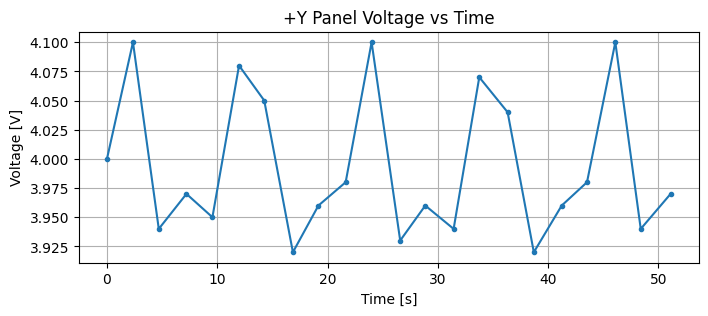

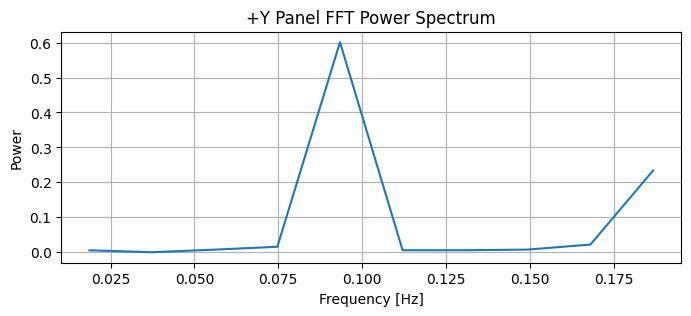

+Y Panel:
  Dominant frequency: 0.0934 Hz
  Angular rotation rate: 0.5869 rad/s
----------------------------------------


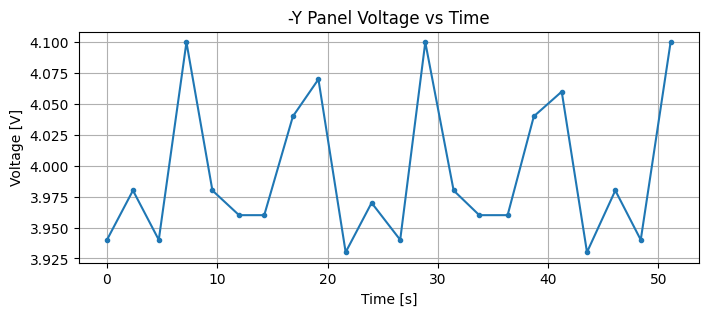

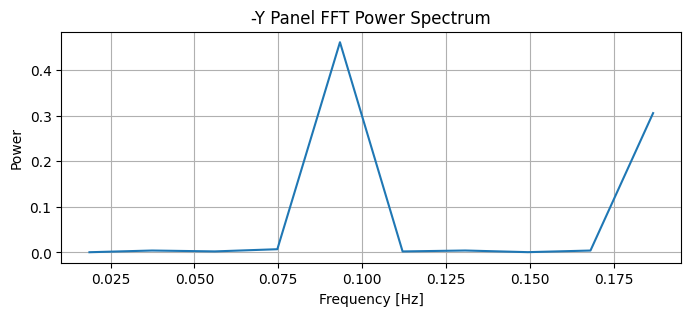

-Y Panel:
  Dominant frequency: 0.0934 Hz
  Angular rotation rate: 0.5869 rad/s
----------------------------------------


In [ ]:
# read in .csv file
df = pd.read_csv("resampled.txt", names=["timestamp", "face", "voltage", "current"], parse_dates=["timestamp"],
                 dtype={"face": str, "voltage": float, "current": float}, skipinitialspace=True)

# Convert timestamp from Cubesat format into seconds
t0 = df["timestamp"].iloc[0]
df["time_sec"] = (df["timestamp"] - t0).dt.total_seconds()

# only Y axis columns have values
panels = ["+Y", "-Y"]
results = {}

for panel in panels:
    df_panel = df[df["face"] == panel].copy()
    # call the analyze_panel function
    freq, omega = analyze_panel(df_panel, panel)
    results[panel] = {"frequency": freq, "angular_rate": omega}

# Q2 - AMSAT Gyro analysis
'Determine the angular acceleration using the onboard accelerometer. How does this compare to what you indirectly
infer from the solar panel voltages, and what can you say
about the accuracy of the two methods, and the tolerance of
the turntables?'

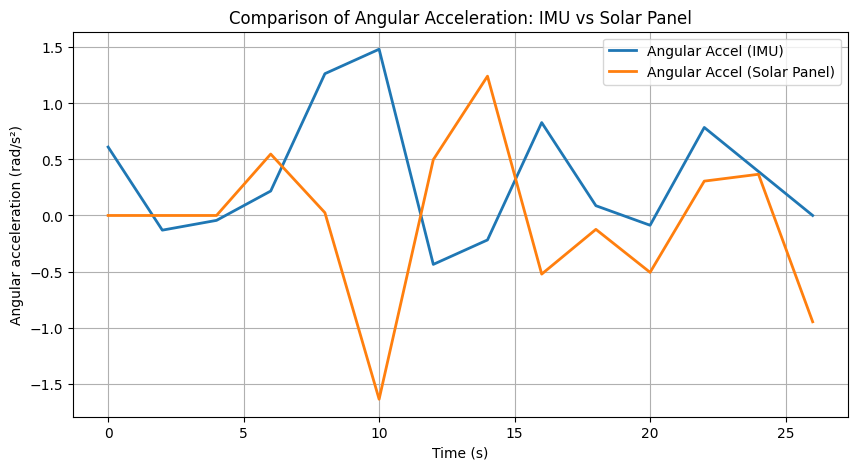

In [ ]:
filename = 'AccvsTime.txt'

ax_list, ay_list, az_list = [], [], []
gx_list, gy_list, gz_list = [], [], []
panel_angle_list = []
time_list = []

t = 0
dt = 2

with open(filename, "r") as f:
  for line in f:
    # extracting the data from the MPU6050 sensor
    if "MPU6050" in line:
      # GenAI was used here. Specifically, ChatGPT-4-Turbo was used for assistance in using regex.
      # Specifically, GenAI provided the syntax needed to use regex
      nums = re.findall(r"[-+]?\d*\.\d+|\d+", line)

      ax = float(nums[0])
      ay = float(nums[1])
      az = float(nums[2])

      gx = float(nums[3])
      gy = float(nums[4])
      gz = float(nums[5])

      xs = float(nums[6])

      ax_list.append(ax)
      ay_list.append(ay)
      az_list.append(az)

      gx_list.append(gx)
      gy_list.append(gy)
      gz_list.append(gz)

      panel_angle_list.append(xs)

      time_list.append(t)
      t += dt

t = np.array(time_list)
ax = np.array(ax_list)
ay = np.array(ay_list)
az = np.array(az_list)
gx = np.array(gx_list)
gy = np.array(gy_list)
gz = np.array(gz_list)

panel = np.array(panel_angle_list)

# Gyro is in milli deg/s, so must convert to rad/s
gyro_x = gx * np.pi/180

# gradient of voltage
#GenAI was used here, specifically ChatGPT-4-Turbo.
# Specifically, GenAI provided the line seen below, in order to
# calculate angular acceleration from the angular velocity data

# While it was known a derivative would be needed to get from velocity to acceleration,
# we struggled with finding a specific method to suit our needs. GenAI suggested using np.gradient.
alpha_imu = np.gradient(gyro_x, dt)

panel_rad = panel * np.pi/180
omega_panel = np.gradient(panel_rad, dt)
alpha_panel = np.gradient(omega_panel, dt)

plt.figure(figsize=(10,5))
plt.plot(t, alpha_imu*1e3, label="Angular Accel (IMU)", linewidth=2)
plt.plot(t, alpha_panel, label="Angular Accel (Solar Panel)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Angular acceleration (rad/s²)")
plt.legend()
plt.grid()
plt.title("Comparison of Angular Acceleration: IMU vs Solar Panel")
plt.show()

# Q3 - Panel degradation analysis

How does the degradation of solar panels affect the output voltage? You can explore this by covering part of the
panels with paper and tape (do not apply tape directly to
the panel surface) or alternatively by carefully coating one
of the panels with chalk dust. How does the voltage and
current change with fraction of the panel that is available?

+Y panel:
  Uncovered mean V: 4.018 V
  Covered mean V  : 3.383 V
  Voltage drop   : 15.8%



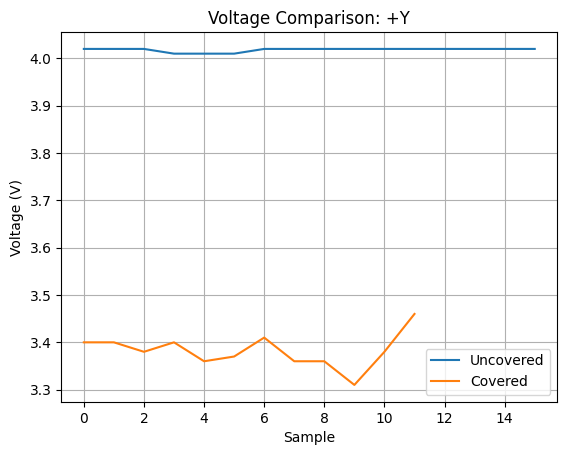

In [ ]:
uncovered = load_panel_voltages("paneldegradation.txt")
covered   = load_panel_voltages("panelnodegradation.txt")

# Compare mean voltages between uncovered and covered panel
for panel in ['+Y']:
  Vu = np.mean(uncovered[panel])
  Vc = np.mean(covered[panel])

  print(f"{panel} panel:")
  print(f"  Uncovered mean V: {Vu:.3f} V")
  print(f"  Covered mean V  : {Vc:.3f} V")

  drop = ((Vu - Vc) / Vu) * 100
  print(f"  Voltage drop   : {drop:.1f}%\n")

plt.plot(uncovered[panel], label="Uncovered")
plt.plot(covered[panel], label="Covered")
plt.title(f"Voltage Comparison for +Y")
plt.xlabel("Sample")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid()
plt.show()


# Q4 - Difference in Query times depending on whether in Ground station or Onboard satellite

When you query a sensor over ssh (perhaps through a
Jupyter notebook) it will take a finite time to execute. What
is the delay introduced by the groundstation (i.e. your computer), compared to on-board processing? Is this constant,
or does this change if the AMSAT is trying to do several
things at once? You can explore this with the time command either from the terminal or through Python

In [6]:
onboard = []
gs = []

filename = 'AMSAT RELAY DATA.txt'
with open(filename, "r") as f:
 curr = None

 for line in f:
  line = line.strip()

  if line == 'Onboard':
    curr = 'onboard'
  elif line == 'Groundstation':
    curr = 'groundstation'
  elif line:
    value = line
    value = float(value)

    if curr == 'onboard':
      onboard.append(value)
    elif curr == 'groundstation':
      gs.append(value)

onboard = np.array(onboard)
gs = np.array(gs)

print(f'Onboard mean: {np.mean(onboard):.3f}')
print(f'Onboard std : {np.std(onboard):.3f}')

print(f'Groundstation mean: {np.mean(gs):.3f}')
print(f'Groundstation std : {np.std(gs):.3f}')

print(f'Extra overhead: {(np.mean(gs) - np.mean(onboard)):.3f}')

Onboard mean: 0.431
Onboard std : 0.013
Groundstation mean: 11.576
Groundstation std : 1.054
Extra overhead: 11.145


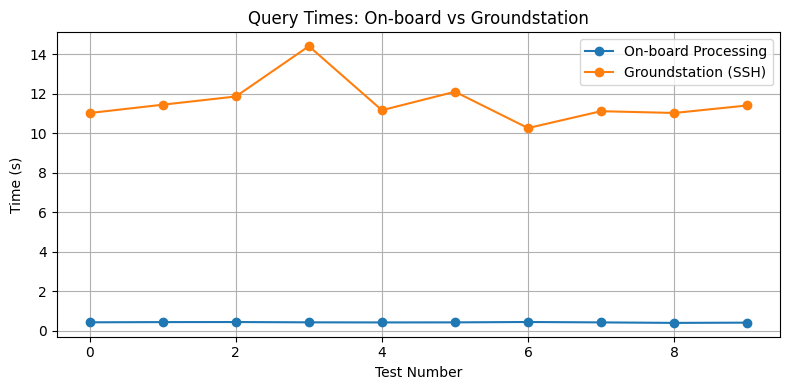

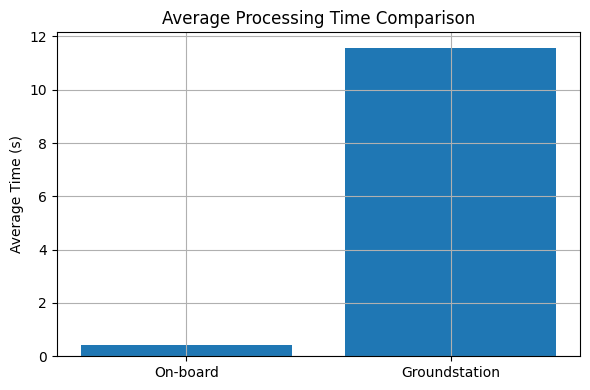

In [7]:
plt.figure(figsize=(8,4))
plt.plot(onboard, marker='o', label="On-board Processing")
plt.plot(gs, marker='o', label="Groundstation (SSH)")
plt.xlabel("Test Number")
plt.ylabel("Time (s)")
plt.title("Query Times: On-board vs Groundstation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

avg_onboard = np.mean(onboard)
avg_ground = np.mean(gs)

plt.figure(figsize=(6,4))
plt.bar(["On-board", "Groundstation"], [avg_onboard, avg_ground])
plt.grid(True)
plt.ylabel("Average Time (s)")
plt.title("Average Processing Time Comparison")
plt.tight_layout()
plt.show()